[INFO] creating Tensor Mesh...
[NOTE] Active cells are being generated
[NOTE] Active cells completed
230 (9760,)
6755 (9760,) (160, 2) (9760,)
[1.00000000e-01 1.83298071e-01 3.35981829e-01 6.15848211e-01
 1.12883789e+00 2.06913808e+00 3.79269019e+00 6.95192796e+00
 1.27427499e+01 2.33572147e+01 4.28133240e+01 7.84759970e+01
 1.43844989e+02 2.63665090e+02 4.83293024e+02 8.85866790e+02
 1.62377674e+03 2.97635144e+03 5.45559478e+03 1.00000000e+04] (35, 2)


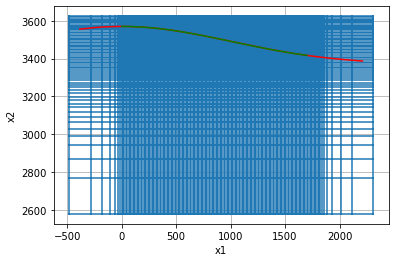

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import unittest
from scipy.constants import mu_0
from discretize.tests import check_derivative
import discretize

from SimPEG.electromagnetics import natural_source as nsem
from SimPEG import (
    maps, utils, optimization, inversion, inverse_problem, directives,
    data_misfit, regularization, data
)
from discretize import TensorMesh
from pymatsolver import Pardiso
import gmsh
# import pyvista as pv


deriv_type = "sigma"
sim_type = "h"
fixed_boundary=True

    
print('[INFO] creating Tensor Mesh...')
mesh = discretize.TensorMesh(
[
    [(200,1),(100,1),(75,1),(50,1),(25,1),(20,1),(15,1),(12.5,146),(15,1),(20,1),(25,1),(50,1),(75,1),(100,1),(200,1)], #[(min cell size,left padding cells, growth factor),(min cell size, amount of cells @ that size),(min cell size,right padding cells, growth factor)]
    [(187.5,1),(100,1),(75,1),(50,1),(37.5,2),(25,3),(18.75,5),(12.5,5),(10,5),(8.75,10),(7.5,15),(6.25,12)]
], x0=[-485, 2580])

mesh.plotGrid()

b = 1000
A = 200

# create topography

Z = A * np.exp(-0.5 * ((mesh.vectorCCx / b) ** 2.0 )) + 3370

topo = np.vstack([mesh.vectorCCx, Z]).T


plt.plot(mesh.vectorCCx, Z, 'r')

print('[NOTE] Active cells are being generated')
actinds = utils.surface2ind_topo(mesh, topo, method='linear')       # active indicies
print('[NOTE] Active cells completed')


# create the synthetic model
sigma_back = 1e-2
sigma_right = 1e-1
sigma_porph = 1
sigma_basement = 1e-3
sigma_air = 1e-8

cells = mesh.cell_centers
sigma = np.ones(mesh.n_cells) * sigma_back
# Conductive sphere
x0 = 700
z0 = 3300
r0 = 100
csph = (
    np.sqrt(
        (mesh.gridCC[:, 0] - x0) ** 2.0
        + (mesh.gridCC[:, 1] - z0) ** 2.0
    )
) < r0
print(csph.sum(), csph.shape)
sigma[csph] = sigma_porph
sigma[cells[:, 1] <= 3200] = sigma_basement
sigma[~actinds] = sigma_air
# sigma = np.log(sigma)


print(actinds.sum(), actinds.shape, topo.shape, sigma.shape)

actmap = maps.InjectActiveCells(

    mesh, indActive=actinds, valInactive=np.log(1e-8)

)

if deriv_type == "sigma":
    sim_kwargs = {"sigmaMap": maps.ExpMap() * actmap}
    test_mod = np.log(sigma)
else:
    sim_kwargs = {"muMap": maps.ExpMap(), "sigma": sigma}
    test_mod = np.log(mu_0) * np.ones(mesh.n_cells)

frequencies = np.logspace(-1, 4, 20)

z_flight_height = A * np.exp(-0.5 * ((np.linspace(0, 1700, 35) / b) ** 2.0 )) + 3370


rx_locs = np.c_[np.linspace(0, 1700, 35), z_flight_height]

plt.plot(rx_locs[:, 0], rx_locs[:, 1], 'g')

print(frequencies, rx_locs.shape)


# if fixed_boundary:

#     actmap = maps.InjectActiveCells(

#         mesh, indActive=actinds, valInactive=np.log(1e-8)

#     )

#     # get field from 1D simulation
#     survey_1d = nsem.Survey(
#         [nsem.sources.Planewave([], frequency=f) for f in frequencies]
#     )
#     mesh_1d = TensorMesh([mesh.h[1]], [mesh.origin[1]])
#     sim_1d = nsem.simulation.Simulation1DMagneticField(
#         mesh_1d, survey=survey_1d, sigmaMap=maps.IdentityMap()
#     )

#     b_left, b_right, _, __ = mesh.cell_boundary_indices
#     f_left = sim_1d.fields(sigma[b_left])
#     f_right = sim_1d.fields(sigma[b_right])

#     b_e = mesh.boundary_edges
#     top = np.where(b_e[:, 1] == mesh.nodes_y[-1])
#     left = np.where(b_e[:, 0] == mesh.nodes_x[0])
#     right = np.where(b_e[:, 0] == mesh.nodes_x[-1])
#     e_bc = {}
#     for src in survey_1d.source_list:
#         e_bc_freq = np.zeros(mesh.boundary_edges.shape[0], dtype=np.complex)
#         e_bc_freq[top] = 1.0
#         e_bc_freq[right] = f_right[src, "e"][:, 0]
#         e_bc_freq[left] = f_left[src, "e"][:, 0]
#         e_bc[src.frequency] = e_bc_freq
#     sim_kwargs["e_bc"] = e_bc

rx_list = [
#     nsem.receivers.PointNaturalSource(
#         rx_locs, orientation="yx", component="real"
#     ),
#     nsem.receivers.PointNaturalSource(
#         rx_locs, orientation="yx", component="imag"
#     ),
#     nsem.receivers.Point3DTipper(
#         rx_locs, orientation="zx", component="imag"
#     ),
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="yx", component="apparent_resistivity"
    ),
    nsem.receivers.PointNaturalSource(
        rx_locs, orientation="yx", component="phase"
    ),
]

src_list = [nsem.sources.Planewave(rx_list, frequency=f) for f in frequencies]

survey = nsem.Survey(src_list)

sim = nsem.simulation.Simulation2DMagneticField(
    mesh,
    survey=survey,
    **sim_kwargs,
    solver=Pardiso,
)

data_obs = sim.dpred(np.log(sigma[actinds]))

# data_obs = data_obs + (data_obs * 0.05)


In [15]:
gmsh.initialize()

gmsh.clear()
gmsh.model.add("t3")


# add the points defining the mesh outline

# add lower left
lc = 10
gmsh.model.geo.addPoint(-500, 2600, 0, lc, 1)
gmsh.model.geo.addPoint(-500, topo[0, 1], 0, lc, 2)
cnt = 0
for ii in range(topo.shape[0]):
    print(ii + 3)
    gmsh.model.geo.addPoint(topo[ii, 0], topo[ii, 1], 0, lc, ii + 3)
    
    cnt += 1
print(ii + 4)
# gmsh.model.geo.addPoint(2210, topo[0, -1], 0, lc, ii + 4)
gmsh.model.geo.addPoint(2210, 2600, 0, lc, ii + 4)
cnt += 1

# create the top points
gmsh.model.geo.addPoint(-500, 3650, 0, lc, 1000)
gmsh.model.geo.addPoint(2210, 3650, 0, lc, 1001)

# create outterbox
gmsh.model.geo.addLine(1, 1000, 1000)
gmsh.model.geo.addLine(1000, 1001, 1001)
gmsh.model.geo.addLine(1001, 163, 1002)
gmsh.model.geo.addLine(163, 1, 1003)

cnt_lines = 0
for ii in range(cnt):
#     print(ii + 1, ii + 2)
    cnt_lines += 1
    gmsh.model.geo.addLine(ii + 1, ii + 2, ii + 1)

print(ii + 2, 1) 
ii += 1
gmsh.model.geo.addLine(ii + 1, ii + 2, cnt_lines + 1)
gmsh.model.geo.addLine(ii + 2, 1, cnt_lines + 2)

surface = np.arange(1, cnt_lines + 2)
print(surface)
gmsh.model.geo.addCurveLoop([1000, 1001, 1002, 1003], 1)
gmsh.model.geo.addCurveLoop(surface.tolist(), 2)
gmsh.model.geo.addPlaneSurface([1], 1)
gmsh.model.geo.synchronize()

# gmsh.model.addPhysicalGroup(1, [1, 2, 4], 5)
# ps = gmsh.model.addPhysicalGroup(2, [1])
# gmsh.model.setPhysicalName(2, ps, "My surface")

# print(topo)
# We can then generate a 2D mesh...
gmsh.model.mesh.generate(1)

# # ... and save it to disk
# gmsh.write("t1.vtk")

# Creates  graphical user interface
# if 'close' not in sys.argv:
gmsh.fltk.run()
  
# It finalize the Gmsh API
gmsh.finalize()


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
162 1
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112

In [2]:
# assign error
rs_error = np.reshape(data_obs, (rx_locs.shape[0] * 2, frequencies.shape[0]))
print(rs_error.shape)

# set some extended use variables
num_sites = rx_locs.shape[0]

eps = 5

for ii in range(rs_error.shape[1]):
    
#     eps = np.percentile(rs_error[:num_sites, ii], 10)
    std_r = 0.1
    std_i = 0.1
    
    rs_error[:num_sites, ii] = np.abs(rs_error[:num_sites, ii]) * std_r + eps
    rs_error[num_sites:, ii] = np.abs(rs_error[num_sites:, ii]) * std_i + 10
    
std = rs_error.flatten('F')
print(std[:5], rs_error[:5, 0])

(70, 20)
[0.17738172 0.16555752 9.06128182 9.07268212 0.23501941] [0.17738172 0.16555752 9.06128182 9.07268212 0.23501941]


(9760,) 6755 (9760,) (160, 2) (9760,) 9760


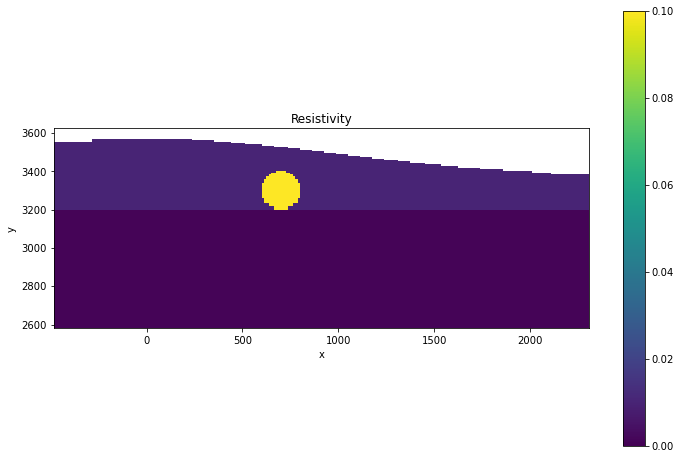

In [3]:
# ==========================================================================================
# Plot synthetic model

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
mtrue = sigma  # np.ones(mesh.nC) * 1 / np.median(rho_app)                        # conductivity
mtrue[~actinds] = np.nan
clim = [0, 0.1]
print(mtrue.shape, actinds.sum(), actinds.shape, topo.shape, sigma.shape, mesh.nC)

dat = mesh.plotImage(((mtrue)), ax=ax, clim=clim, grid=False,
#                      gridOpts={'alpha': 0.2},
                     pcolorOpts={"cmap": "viridis"}
                    )
ax.set_title('Resistivity')
cb = plt.colorbar(dat[0], ax=ax)
# ax.set_xlim([-300, 4300])
# ax.set_ylim([-400, 0])
ax.set_aspect('equal')
# ax.plot(
#     survey_dc.electrode_locations[:, 0],
#     survey_dc.electrode_locations[:, 1], 'k.'
# )
plt.show()

# np.save('conductivity.npy', rho_est)

(1400,)


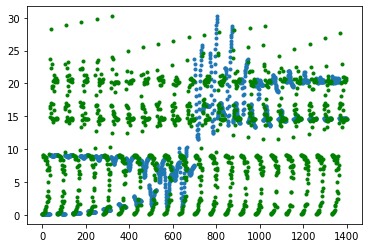

In [4]:
# eps = 1e-5
# std = abs(data_obs * 0.08) + eps
# plt.loglog(frequencies, data_obs[:20], '.')
plt.plot(data_obs, '.')
print(data_obs.shape)
plt.plot(std, '.g')

In [5]:
#np.percentile(np.abs(data_obs), 10, interpolation='lower')
m0 = (np.ones(mesh.nC) * np.log(sigma_back))[actinds]
# m0[~actinds] = np.log(1e-8)
# std = abs(data_obs * 0.05) + eps
data_t = data.Data(survey, dobs=data_obs, standard_deviation=std)
# Clean sensitivity function formed with true resistivity
sim._Jmatrix = None

# Data Misfit
coolingFactor = 2
coolingRate = 1
beta0_ratio = 1e1
dmisfit = data_misfit.L2DataMisfit(data=data_t, simulation=sim)

# check for percentile floor

# print(uncert.shape)
dmisfit.W = 1. / std
# Map for a regularization
regmap = maps.IdentityMap(nP=int(actinds.sum()))
# reg = regularization.Tikhonov(mesh, indActive=actinds, mapping=regmap)
reg = regularization.Sparse(mesh, indActive=actinds, mapping=regmap)

print('[INFO] Getting things started on inversion...')
# set alpha length scales
reg.alpha_s = 1
reg.alpha_x = 1
reg.alpha_y = 1
reg.alpha_z = 1
# plot uncertainties
# opt = Optimization.InexactGaussNewton(maxIter=6)
# opt = Optimization.GaussNewton(maxIter=15)
opt = optimization.ProjectedGNCG(maxIter=10, upper=np.inf, lower=-np.inf)
invProb = inverse_problem.BaseInvProblem(dmisfit, reg, opt)
beta = directives.BetaSchedule(
    coolingFactor=coolingFactor, coolingRate=coolingRate
)
betaest = directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)
target = directives.TargetMisfit()
target.target = survey.nD / 2.
saveIter = directives.SaveModelEveryIteration()
saveIterVar = directives.SaveOutputEveryIteration()

directiveList = [
    beta, betaest, target, saveIter, saveIterVar 
]

inv = inversion.BaseInversion(
    invProb, directiveList=directiveList)
# opt.LSshorten = 0.5
opt.remember('xc')

# Run Inversion ======================================================
minv = inv.run(m0)

[INFO] Getting things started on inversion...
SimPEG.InvProblem will set Regularization.mref to m0.

        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
        ***Done using same Solver and solverOpts as the problem***
SimPEG.SaveModelEveryIteration will save your models as: '.\###-InversionModel-2022-08-07-19-17.npy'
SimPEG.SaveOutputEveryIteration will save your inversion progress as: '###-InversionModel-2022-08-07-19-17.txt'
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  7.61e+00  6.00e+06  0.00e+00  6.00e+06    3.96e+05      0              
   1  3.80e+00  1.30e+06  7.10e+04  1.57e+06    7.50e+04      0              
   2  1.90e+00  5.97e+05  1.28e+05  8.40e+05    2.69e+04      0   Skip BFGS  
   3  9.51e-01  3.88e+05  1.68e+0

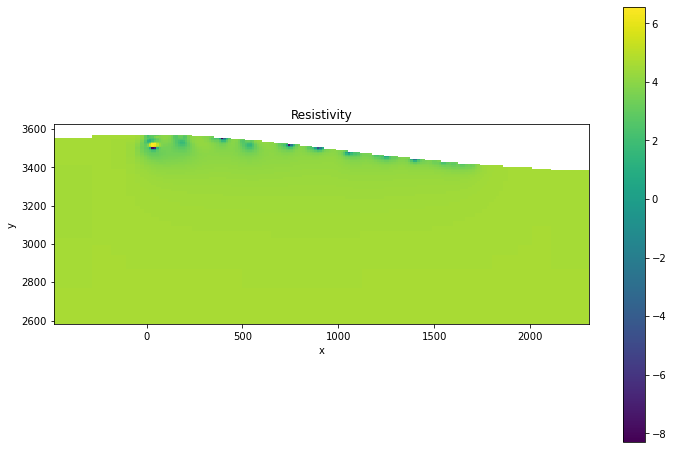

In [6]:
# ==========================================================================================
# Plot inversion results
rho_est = actmap * minv
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
mtrue = 1 / np.exp(rho_est)  # np.ones(mesh.nC) * 1 / np.median(rho_app)                        # conductivity
mtrue[~actinds] = np.nan
clim = [0, 5]

dat = mesh.plotImage(((np.log(mtrue))), ax=ax, grid=False,
                     pcolorOpts={"cmap": "viridis"}
                    )
ax.set_title('Resistivity')
cb = plt.colorbar(dat[0], ax=ax)
# ax.set_xlim([-300, 4300])
# ax.set_ylim([-400, 0])
ax.set_aspect('equal')
# ax.plot(
#     survey_dc.electrode_locations[:, 0],
#     survey_dc.electrode_locations[:, 1], 'k.'
# )
plt.show()

np.save('conductivity.npy', rho_est)

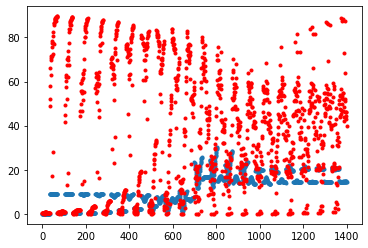

In [7]:
plt.plot(data_obs, '.')
plt.plot(invProb.dpred, '.r')